In [1]:
import numpy as np
import pandas as pd
import math as m
import datetime as dt
import torch
import os
import math as m

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [86]:
class dataset_preprocessing():
    
    ORIGIN_LATITUDE  = 27.0
    ORIGIN_LONGITUDE = 127.0
    EARTH_RADIUS     = 6373.0
        
    def __init__(self, data_path, sep=' '):
        self.data_path = data_path
        self.sep = sep
    
    def read_data(self):
        self.data = pd.read_csv(self.data_path, sep=self.sep)
        
    def rename_cols(self):
        self.data = self.data.rename(
                                    columns={'YYYY': 'year', 
                                             'MM': 'month',
                                             'DD': 'date',
                                             'HH': 'hour',
                                             'mm': 'minute',
                                             'ssss': 'seconds',
                                             'LAT': 'lat',
                                             'LONG': 'long',
                                             'Depth': 'depth',
                                             'Class': 'class'}
                                )
        
    def spherical_to_cartesian (self, longitude, latitude):
        X = (longitude - self.ORIGIN_LONGITUDE) * m.pi / 180 * self.EARTH_RADIUS * m.cos (latitude * m.pi / 180)
        Y = (latitude  - self.ORIGIN_LATITUDE ) * m.pi / 180 * self.EARTH_RADIUS 

        return X, Y
        
    def projecting_japan_to_plane(self):
        
        XY_massive = np.zeros((self.data.shape[0], 2))
        j = 0
        
        for i in tqdm(range (XY_massive.shape[0])):
            XY_massive[i][0], XY_massive[i][1] = self.spherical_to_cartesian (self.data['long'][i], self.data['lat'][i])

        self.data['x'] = XY_massive[:, 0]
        self.data['y'] = XY_massive[:, 1]
        
    def calc_days_from_d0(self, d_0):
        time_massive = np.zeros (self.data.shape[0])
        
        for i in tqdm(range (self.data.shape[0])):
            d_i = dt.date (self.data['year'][i], self.data['month'][i], self.data['date'][i])
            time_massive[i] = (d_i - d_0).days

        self.data['time'] = time_massive
        
    def __call__(self):
        
        print(f'read_data . . . {self.data_path}')
        self.read_data()
        self.rename_cols()
        
        print('projecting_japan_to_plane . . . ')
        self.projecting_japan_to_plane()
        
        print('calc_days_from_d0 . . . ')
        self.calc_days_from_d0(
                                 d_0=dt.date(self.data['year'][0], self.data['month'][0],self. data['date'][0])
                              )
        print('done')
        
        return self.data
    
def plot_data(data, title = 'Данные'):
    fig = plt.figure(figsize=(10, 12.5))

    plt.scatter(data['x'], data['y'], color='orange', marker='.', s=10)

    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.title(title)

    plt.show()


def create_celled_data(
    data,
    mode='count',  # 'count' or 'max'
    zero_date=0,
    left_border=0,
    right_border=2000,
    down_border=0,
    up_border=2500,
    n_cells_hor=200,
    n_cells_ver=250,
    min_magn=3.5,
    mask = (200, 1800, -5, 1800)
):
    """
    Generates a gridded earthquake map with two possible modes:
    - 'count': Number of earthquakes per grid cell within a time window
    - 'max':   Maximum magnitude per grid cell within a time window

    Args:
        mode: Operation mode ('count' or 'max')
        data: DataFrame containing columns ['x', 'y', 'time', 'class'] (coordinates, timestamp, magnitude)
        left_border, right_border, down_border, up_border: Area boundaries in coordinate units
        n_cells_hor, n_cells_ver: Grid resolution (horizontal/vertical cells)
        min_magn: Minimum magnitude threshold for filtering events

    Returns:
        torch.Tensor: 4D tensor of shape [days, 1, grid_width, grid_height]
    """
    # Filter earthquakes below magnitude threshold
    data = data[data["class"] > min_magn].reset_index(drop=True)
    
    # Validate mode parameter
    if mode not in ['count', 'max']:
        raise ValueError("Mode must be either 'count' or 'max'")

    indicies = range(data.shape[0])
    start_date = int(data['time'][indicies[0]]) + zero_date + 1 # skip first 5 years for non empty baselines
    finish_date = int(data['time'][indicies[-1]])
    
    # Initialize output tensor (days × grid_width × grid_height)
    celled_data = torch.zeros([finish_date - start_date + 1, n_cells_hor, n_cells_ver])

    # Calculate grid cell sizes
    cell_size_hor = (right_border - left_border) / n_cells_hor
    cell_size_ver = (up_border - down_border) / n_cells_ver

    for i in indicies:
        # Check if event is within spatial boundaries
        if ((data['x'][i] > left_border) and
            (data['x'][i] < right_border) and
            (data['y'][i] > down_border) and
            (data['y'][i] < up_border)):
            
            # Convert coordinates to grid indices
            x = int(data['x'][i] / cell_size_hor)
            y = int(data['y'][i] / cell_size_ver)
            
            # Calculate time indices for the sliding window
            cur_time = int(data['time'][i]) - start_date
            selection_mask = (
                    (data['time'] == data['time'][i]) &
                    (data['x'] == data['x'][i]) &
                    (data['y'] == data['y'][i])
            )
            
            # Apply selected aggregation mode
            if mode == 'count':
                celled_data[cur_time, x, y] += data[selection_mask]['class'].count()
            else:  # mode == 'max'
                celled_data[cur_time, x, y] = max(
                    celled_data[cur_time, x, y], 
                    data[selection_mask]['class'].max()
                )
    
    celled_data = celled_data[
        :, 
        int(mask[0] / cell_size_hor):int(mask[1] / cell_size_hor),
        int(mask[2] / cell_size_ver):int(mask[3] / cell_size_ver),
    ]
    
    return celled_data
    
def plot_freq_map(celled_data, title_list = None):
    cmap_names = ['Oranges', 'Blues', 'Greys', 'Purples', 'Greens',  'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    
    col_maps = celled_data.shape[1]
    
    if col_maps == 1:
        fig = plt.gcf()
        fig.set_size_inches(6, 5)
        fig.set_dpi(100)
        
        freq_map = (celled_data).float().mean(dim=0)
        plt.imshow (freq_map.squeeze(0), cmap=cmap_names[0])
        plt.colorbar()
        if title_list is not None:
            plt.title(title_list[0])
        
    elif col_maps > 1:
        f, axes = plt.subplots(1, col_maps, sharey=True)
        f.set_size_inches(13, 5)
        f.set_dpi(100)
        for map_num in range(col_maps):
            freq_map = (celled_data[:, map_num, ...]).float().mean(dim=0)
            img = axes[map_num].imshow (freq_map.squeeze(0), cmap=cmap_names[map_num])
            if title_list is not None:
                axes[map_num].set_title(title_list[map_num])
            plt.colorbar(img, ax = axes[map_num])

### Let's look what we have

In [3]:
DATA_PATH_CAT_ORIG = '../data/catalogues/originalCat.csv'
DATA_PATH_CAT_WITHOUTAFT = '../data/catalogues/withoutAftCat.csv'

### prerocessing data

In [4]:
datacat_orig_preprocess_pipeline = dataset_preprocessing(DATA_PATH_CAT_ORIG)
datacat_withoutaft_preprocess_pipeline = dataset_preprocessing(DATA_PATH_CAT_WITHOUTAFT)

In [5]:
data_cat_orig = datacat_orig_preprocess_pipeline()

read_data . . . ../data/catalogues/originalCat.csv
projecting_japan_to_plane . . . 


  0%|          | 0/3234319 [00:00<?, ?it/s]

calc_days_from_d0 . . . 


  0%|          | 0/3234319 [00:00<?, ?it/s]

done


In [53]:
data_cat_orig[data_cat_orig["class"] > 3.5]

,year,month,date,hour,minute,seconds,lat,long,depth,class,x,y,time
133,2004,3,7,5,9,36.0,38.958,141.699,64.2,3.9,1271.362144,1330.086346,1.0
148,2004,3,7,6,49,53.0,35.609,139.395,139.1,3.8,1120.890883,957.577634,1.0
206,2004,3,7,12,25,42.0,36.333,143.287,73.0,4.1,1459.401960,1038.108034,1.0
542,2004,3,8,21,50,38.0,41.407,142.442,35.9,3.6,1288.260305,1602.488207,2.0
791,2004,3,9,22,56,37.0,33.989,132.751,42.5,3.6,530.389716,777.385304,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3233855,2023,7,9,22,52,22.0,35.661,140.420,65.8,4.5,1212.793250,963.361586,7064.0
3233986,2023,7,10,4,40,51.0,35.708,140.654,50.4,4.0,1233.213600,968.589388,7065.0
3234063,2023,7,10,8,12,30.0,30.523,142.167,70.0,4.6,1453.244279,391.862702,7065.0
3234244,2023,7,10,15,25,48.0,37.031,140.962,72.6,4.0,1239.767849,1115.746457,7065.0


In [59]:
len(data_cat_orig[data_cat_orig["class"] > 3.5])

35854

In [8]:
len(data_cat_orig[data_cat_orig["class"] > 6.0])

243

In [10]:
data_cat_orig[data_cat_orig["class"] > 6.0].year.unique()

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [49]:
data_cat_orig['time'][2]

0.0

In [54]:
data_cat_orig[
    (data_cat_orig["class"] > 3.5) 
      & (data_cat_orig['time'] == 1)
]['class'].count()

3

In [8]:
data_cat_orig.x.max(), data_cat_orig.x.min()

(1741.2327014916166, 204.9724888481744)

In [9]:
data_cat_orig.y.max(), data_cat_orig.y.min()

(1784.0152951695322, -4.337963495954511)

In [11]:
data_without_aft_cat = datacat_withoutaft_preprocess_pipeline()

read_data . . . ../data/catalogues/withoutAftCat.csv
projecting_japan_to_plane . . . 


  0%|          | 0/1273735 [00:00<?, ?it/s]

calc_days_from_d0 . . . 


  0%|          | 0/1273735 [00:00<?, ?it/s]

done


In [67]:
len(data_without_aft_cat[data_without_aft_cat["class"] > 3.5])

7780

In [68]:
len(data_without_aft_cat[data_without_aft_cat["class"] > 6.0])

105

In [30]:
data_without_aft_cat[data_without_aft_cat["class"] > 6.0].year.unique()

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

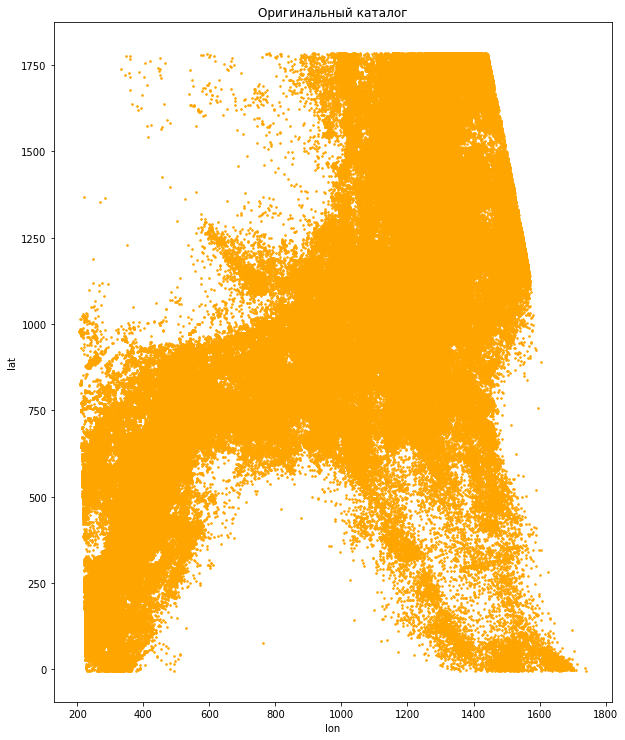

In [12]:
plot_data(data_cat_orig, title='Оригинальный каталог')

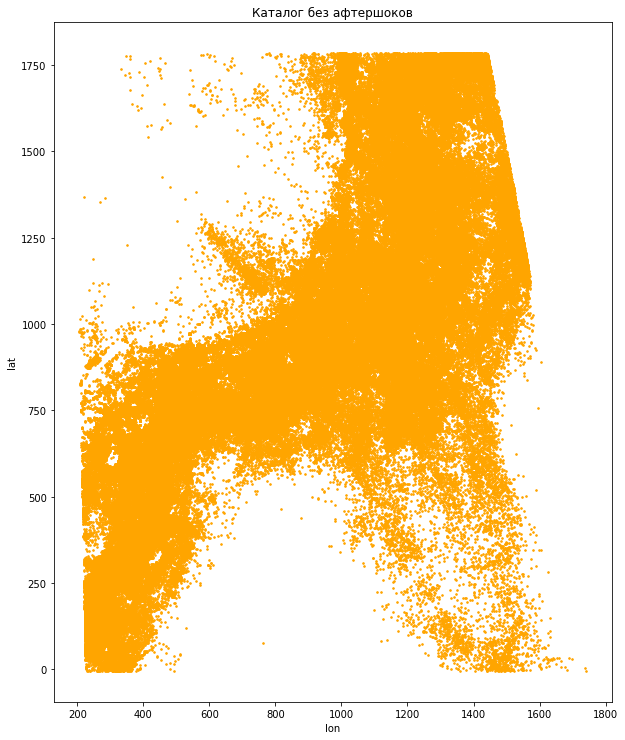

In [13]:
plot_data(data_without_aft_cat, title='Каталог без афтершоков')

## Creating dataset by days and cells

In [87]:
LEFT_BORDER = 0
RIGHT_BORDER = 2000
DOWN_BORDER = 0
UP_BORDER = 2500
N_CELLS_HOR = 200
N_CELLS_VER = 250

dataset_variants = [
    {"data_type": "orig", "min_magn": 3.0, "mode": "count"}, # for weights
    
    {"data_type": "orig", "min_magn": 3.5, "mode": "count"},
    {"data_type": "orig", "min_magn": 3.5, "mode": "max"},
    
    {"data_type": "withoutfat", "min_magn": 3.5, "mode": "count"},
    {"data_type": "withoutfat", "min_magn": 3.5, "mode": "max"},
    
    {"data_type": "orig", "min_magn": 6.0, "mode": "count"},
    {"data_type": "orig", "min_magn": 6.0, "mode": "max"},
    
    {"data_type": "withoutfat", "min_magn": 6.0, "mode": "count"},
    {"data_type": "withoutfat", "min_magn": 6.0, "mode": "max"},
]

In [88]:
for dataset_variant in tqdm(dataset_variants):
    if dataset_variant["data_type"] == "orig":
        data = data_cat_orig
    else:
        data = data_without_aft_cat

    pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_{dataset_variant['mode']}"

    celled_data = create_celled_data(
        data,
        min_magn=dataset_variant["min_magn"],
        left_border = LEFT_BORDER,
        right_border = RIGHT_BORDER,
        down_border = DOWN_BORDER,
        up_border = UP_BORDER,
        n_cells_hor = N_CELLS_HOR,
        n_cells_ver = N_CELLS_VER
    ) #.to(torch.int16)

    torch.save(celled_data, pn)

  0%|          | 0/9 [00:00<?, ?it/s]

data/orig_3.0_count torch.Size([7065, 160, 180]) 81903.0


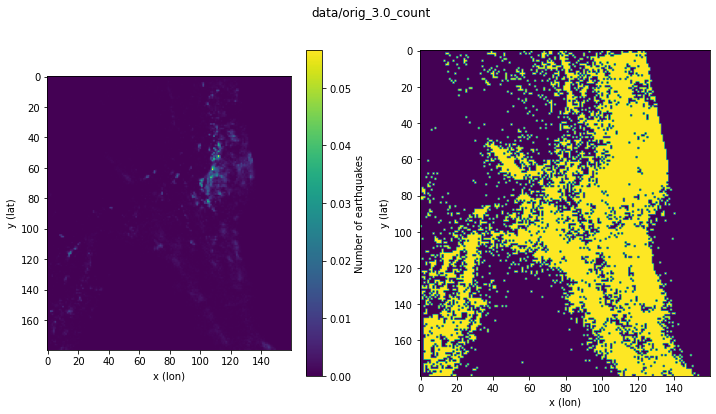

data/orig_3.5_count torch.Size([7064, 160, 180]) 35797.0


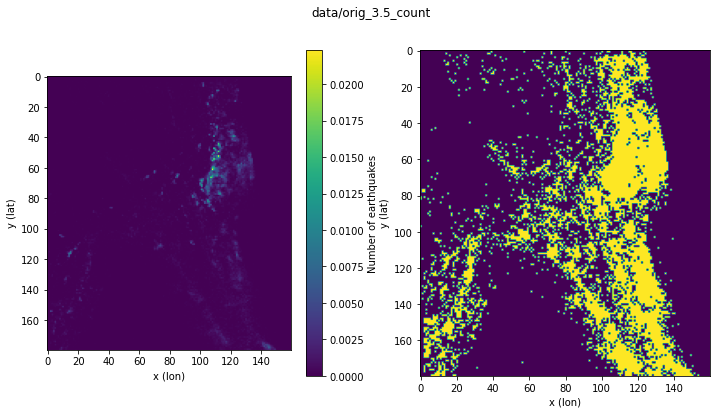

data/withoutfat_3.5_count torch.Size([7064, 160, 180]) 7767.0


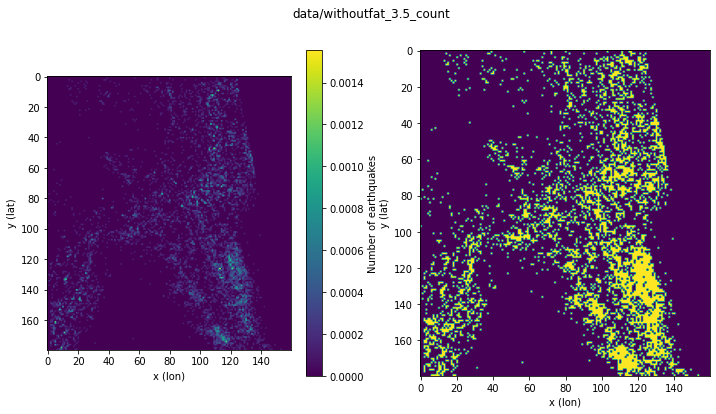

data/orig_6.0_count torch.Size([6968, 160, 180]) 243.0


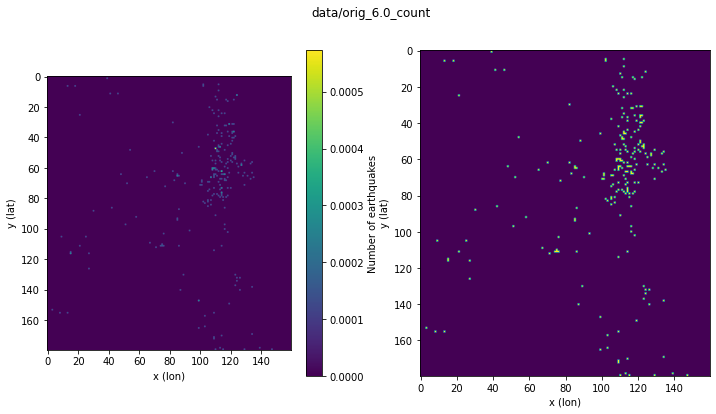

data/withoutfat_6.0_count torch.Size([6968, 160, 180]) 105.0


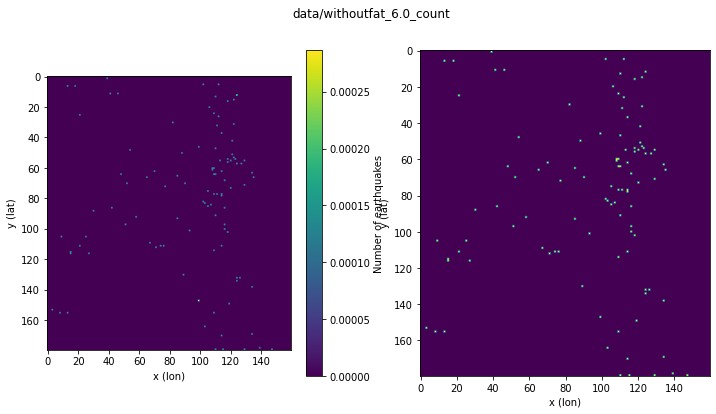

In [91]:
for dataset_variant in [dataset_variants[i] for i in [0, 1, 3, 5, 7]]:
    pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_{dataset_variant['mode']}"

    celled_data = torch.load(pn) #.to(torch.float16)

    print(pn, celled_data.shape, celled_data.sum().numpy())
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    array = (celled_data.transpose(1, 2).mean(axis=0)).numpy()[::-1]
    axes[0].imshow(array, cmap='viridis')
    fig.colorbar(axes[0].imshow(array, cmap='viridis'), ax=axes[0], label='Number of earthquakes')
    axes[0].set_xlabel('x (lon)')
    axes[0].set_ylabel('y (lat)')
    
    array = array = (celled_data.transpose(1, 2).sum(axis=0) > 0).numpy()[::-1]
    axes[1].imshow(array, cmap='viridis')
#     fig.colorbar(axes[1].imshow(array, cmap='viridis'), ax=axes[0], label='Binary map of earthquakes')
    axes[1].set_xlabel('x (lon)')
    axes[1].set_ylabel('y (lat)')
    
    plt.suptitle(pn)
    plt.show()